## Data Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, log_loss, classification_report, confusion_matrix,
    ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score
)
from sklearn.inspection import permutation_importance

In [2]:
np.random.seed(42)
data = pd.read_csv("titanic_augmented.csv")
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PassengerId        891 non-null    int64  
 1   Survived           891 non-null    int64  
 2   Pclass             891 non-null    int64  
 3   Name               891 non-null    object 
 4   Sex                891 non-null    object 
 5   Age                714 non-null    float64
 6   SibSp              891 non-null    int64  
 7   Parch              891 non-null    int64  
 8   Ticket             891 non-null    object 
 9   Fare               891 non-null    float64
 10  Cabin              204 non-null    object 
 11  Embarked           889 non-null    object 
 12  name_length        891 non-null    int64  
 13  title              891 non-null    object 
 14  title_group        891 non-null    object 
 15  family_size        891 non-null    int64  
 16  is_alone           891 non

PassengerId            0
Survived               0
Pclass                 0
Name                   0
Sex                    0
Age                  177
SibSp                  0
Parch                  0
Ticket                 0
Fare                   0
Cabin                687
Embarked               2
name_length            0
title                  0
title_group            0
family_size            0
is_alone               0
ticket_group_size      0
fare_per_person        0
age_fare_ratio         0
cabin_deck             0
cabin_room_number    691
booking_reference      0
service_id             0
cabin_score            0
name_word_count        0
dtype: int64

In [3]:
#dropping unnecessary columns to avoid overfitting
#unnecessary = PassengerId, Name, Ticket, name_length, service_id, booking_reference, name_word_count
#potentially helpful but not really possible to guess missing values accurately (median or mode would give random answer) = Cabin, cabin_room_number
#dropped title because title and title_group give same information
#cabin_deck is mostly Unknown so this is not helpful for most passengers

data = data.drop(["PassengerId", "Name", "Ticket", "Cabin", "name_length", "title", "cabin_deck", "service_id", "cabin_room_number", "booking_reference", "name_word_count"], axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Survived           891 non-null    int64  
 1   Pclass             891 non-null    int64  
 2   Sex                891 non-null    object 
 3   Age                714 non-null    float64
 4   SibSp              891 non-null    int64  
 5   Parch              891 non-null    int64  
 6   Fare               891 non-null    float64
 7   Embarked           889 non-null    object 
 8   title_group        891 non-null    object 
 9   family_size        891 non-null    int64  
 10  is_alone           891 non-null    int64  
 11  ticket_group_size  891 non-null    int64  
 12  fare_per_person    891 non-null    float64
 13  age_fare_ratio     891 non-null    float64
 14  cabin_score        891 non-null    float64
dtypes: float64(5), int64(7), object(3)
memory usage: 104.5+ KB


In [4]:
#define the predictors and response

y = data["Survived"]
X = data.drop("Survived", axis = 1)

X.info()
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Pclass             891 non-null    int64  
 1   Sex                891 non-null    object 
 2   Age                714 non-null    float64
 3   SibSp              891 non-null    int64  
 4   Parch              891 non-null    int64  
 5   Fare               891 non-null    float64
 6   Embarked           889 non-null    object 
 7   title_group        891 non-null    object 
 8   family_size        891 non-null    int64  
 9   is_alone           891 non-null    int64  
 10  ticket_group_size  891 non-null    int64  
 11  fare_per_person    891 non-null    float64
 12  age_fare_ratio     891 non-null    float64
 13  cabin_score        891 non-null    float64
dtypes: float64(5), int64(6), object(3)
memory usage: 97.6+ KB
<class 'pandas.core.series.Series'>
RangeIndex: 891 entries, 0 t

In [5]:
#as seen in first step, age and embarked have missing values so we should fill with median for numeric or mode for categorical

#numerical (assigning median from each title_group to people within that title_group to give more accurate age estimates)
X["Age"].fillna(X[X["title_group"]=="Mr"]["Age"].median(), inplace=True)
X["Age"].fillna(X[X["title_group"]=="Mrs"]["Age"].median(), inplace=True)
X["Age"].fillna(X[X["title_group"]=="Miss"]["Age"].median(), inplace=True)
X["Age"].fillna(X[X["title_group"]=="Master"]["Age"].median(), inplace=True)
X["Age"].fillna(X[X["title_group"]=="Other"]["Age"].median(), inplace=True)

#categorical
X["Embarked"] = X["Embarked"].fillna(X["Embarked"].mode()[0])

X.isnull().sum()

/var/folders/k4/sj8k9zyx0xl3bxnvlt_d3b3c0000gn/T/ipykernel_26258/2076984404.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X["Age"].fillna(X[X["title_group"]=="Mr"]["Age"].median(), inplace=True)
/var/folders/k4/sj8k9zyx0xl3bxnvlt_d3b3c0000gn/T/ipykernel_26258/2076984404.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we

Pclass               0
Sex                  0
Age                  0
SibSp                0
Parch                0
Fare                 0
Embarked             0
title_group          0
family_size          0
is_alone             0
ticket_group_size    0
fare_per_person      0
age_fare_ratio       0
cabin_score          0
dtype: int64

In [6]:
#make dummy variables

X = pd.get_dummies(X, columns = ["Sex", "Embarked", "title_group"], drop_first = True, dtype = int)

In [7]:
#split into training and testing

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify = y, random_state=42)

## Logistic Regression (Ilakiya)

In [8]:
numeric_features = X_train.columns 

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features)
    ]
)

In [9]:
pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000, random_state=0))
])

param_grid = {
    "model__C": [0.01, 0.1, 1, 10, 50],
    "model__penalty": ["l2"],
    "model__solver": ["lbfgs"]
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,               
    scoring="roc_auc",
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV AUC:", grid.best_score_)
best_model = grid.best_estimator_

Best params: {'model__C': 0.1, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Best CV AUC: 0.863082680573303


In [10]:
#Model Evaluation (Test Set)
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

test_acc = accuracy_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_prob)

print("Test Accuracy:", test_acc)
print("Test AUC:", test_auc)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Test Accuracy: 0.8116591928251121
Test AUC: 0.8566457307757597

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.86      0.85       137
           1       0.77      0.73      0.75        86

    accuracy                           0.81       223
   macro avg       0.80      0.80      0.80       223
weighted avg       0.81      0.81      0.81       223



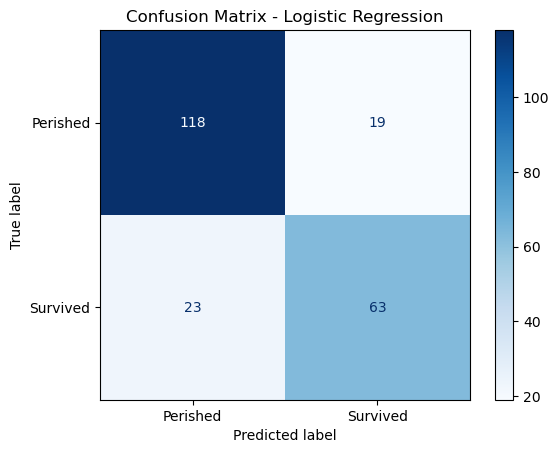

In [11]:
#Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=["Perished", "Survived"],
    cmap="Blues"   
)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


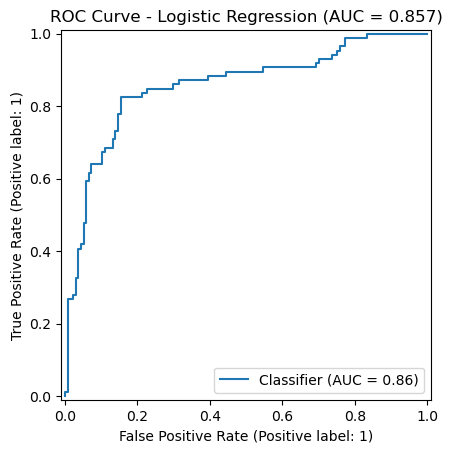

In [12]:
#ROC Curve + AUC 

RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title(f"ROC Curve - Logistic Regression (AUC = {test_auc:.3f})")
plt.show()

In [13]:
#Feature Importance - Logistic Regression Coefficients

# Get the feature names after one-hot encoding
all_feature_names = X_train.columns

coefs = best_model.named_steps["model"].coef_[0]

coef_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Coefficient": coefs,
    "AbsCoeff": np.abs(coefs)
}).sort_values("AbsCoeff", ascending=False)

coef_df.head(15)

,Feature,Coefficient,AbsCoeff
15,title_group_Mr,-0.862500,0.862500
0,Pclass,-0.708074,0.708074
11,Sex_male,-0.378575,0.378575
1,Age,-0.353796,0.353796
4,Fare,0.249960,0.249960
2,SibSp,-0.230633,0.230633
10,cabin_score,0.214655,0.214655
16,title_group_Mrs,0.197800,0.197800
5,family_size,-0.195592,0.195592
17,title_group_Other,-0.173204,0.173204


## KNN (Karthik)

In [14]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

baseline_pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", KNeighborsClassifier())
])

param_grid = {
    "model__n_neighbors": [3, 5, 7, 9, 11, 15, 21, 31],
    "model__weights": ["uniform", "distance"],
    "model__p": [1, 2]
}

grid = GridSearchCV(
    baseline_pipe,
    param_grid=param_grid,
    scoring="neg_log_loss",
    cv=cv,
    n_jobs=-1
)

grid.fit(X_train, y_train)
best_all = grid.best_estimator_

print("\n====================")
print("Best KNN (ALL features)")
print("====================")
print("Best params:", grid.best_params_)
print("Best CV neg_log_loss:", grid.best_score_)

proba_test_all = best_all.predict_proba(X_test)
pred_test_all = best_all.predict(X_test)

print("\n--- Test results (ALL features) ---")
print("Accuracy:", accuracy_score(y_test, pred_test_all))
print("Log Loss:", log_loss(y_test, proba_test_all))
print("Confusion Matrix:\n", confusion_matrix(y_test, pred_test_all))
print(classification_report(y_test, pred_test_all))


Best KNN (ALL features)
Best params: {'model__n_neighbors': 31, 'model__p': 2, 'model__weights': 'distance'}
Best CV neg_log_loss: -0.44875655938584397

--- Test results (ALL features) ---
Accuracy: 0.8251121076233184
Log Loss: 0.46624049081359054
Confusion Matrix:
 [[121  16]
 [ 23  63]]
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       137
           1       0.80      0.73      0.76        86

    accuracy                           0.83       223
   macro avg       0.82      0.81      0.81       223
weighted avg       0.82      0.83      0.82       223



              feature  importance       std
0                 Age    0.152994  0.004481
1         cabin_score    0.150299  0.004929
2      age_fare_ratio    0.140569  0.007438
3     fare_per_person    0.109581  0.005347
4                Fare    0.107635  0.005030
5              Pclass    0.103443  0.007255
6         family_size    0.098952  0.002164
7   ticket_group_size    0.096707  0.007551
8            is_alone    0.088323  0.006491
9      title_group_Mr    0.086078  0.006289
10              SibSp    0.079192  0.005333
11           Sex_male    0.077395  0.006493
12         Embarked_S    0.069012  0.003694
13              Parch    0.065569  0.006886
14   title_group_Miss    0.062874  0.004874
15    title_group_Mrs    0.050898  0.004181
16         Embarked_Q    0.025749  0.003466
17  title_group_Other    0.011976  0.001771


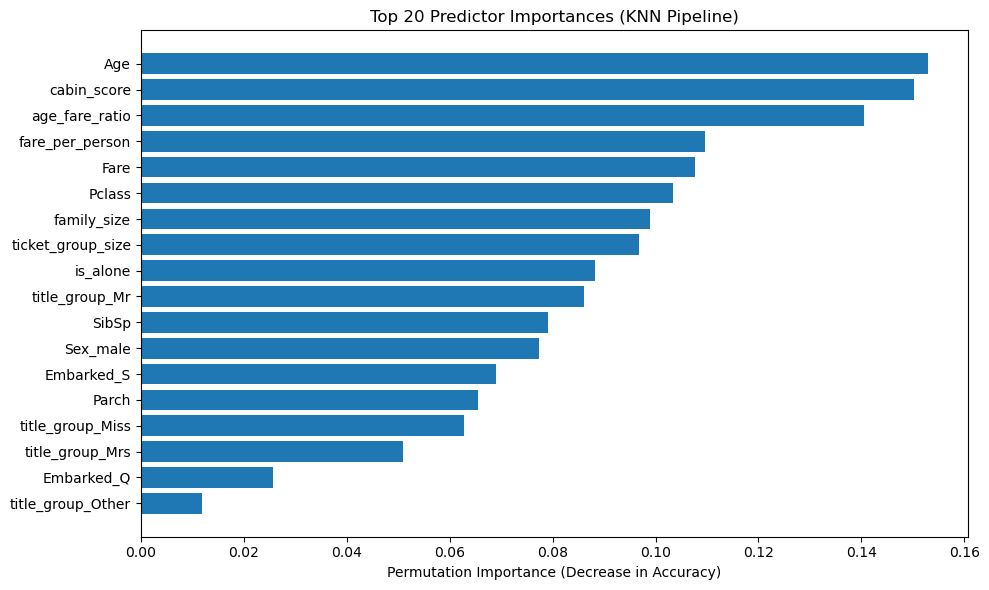

In [15]:
feature_names = X_train.columns.to_numpy()

perm = permutation_importance(
    best_all,          # pipeline
    X_train, y_train,  # raw inputs
    n_repeats=10,
    random_state=42,
    scoring="accuracy",
    n_jobs=-1
)

importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": perm.importances_mean,
    "std": perm.importances_std
}).sort_values("importance", ascending=False).reset_index(drop=True)

print(importance_df.head(30))

# Plot top N
top_n = 20
plot_df = importance_df.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(plot_df["feature"][::-1], plot_df["importance"][::-1])
plt.xlabel("Permutation Importance (Decrease in Accuracy)")
plt.title(f"Top {top_n} Predictor Importances (KNN Pipeline)")
plt.tight_layout()
plt.show()

In [16]:
threshold = 0.005
selected_features = importance_df.loc[importance_df["importance"] > threshold, "feature"].tolist()

min_features = 7
if len(selected_features) < min_features:
    selected_features = importance_df["feature"].head(min_features).tolist()

print("\n====================")
print("Selected features for FINAL model")
print("====================")
print("Count:", len(selected_features))
print(selected_features)



Selected features for FINAL model
Count: 18
['Age', 'cabin_score', 'age_fare_ratio', 'fare_per_person', 'Fare', 'Pclass', 'family_size', 'ticket_group_size', 'is_alone', 'title_group_Mr', 'SibSp', 'Sex_male', 'Embarked_S', 'Parch', 'title_group_Miss', 'title_group_Mrs', 'Embarked_Q', 'title_group_Other']


In [17]:
name_to_idx = {n: i for i, n in enumerate(feature_names)}
selected_idx = [name_to_idx[f] for f in selected_features]

# FunctionTransformer expects a function; we capture selected_idx via closure
select_columns = FunctionTransformer(
    func=lambda Z: Z[:, selected_idx],
    validate=False
)

final_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("select_cols", select_columns),
    ("model", KNeighborsClassifier(
        n_neighbors=grid.best_params_["model__n_neighbors"],
        weights=grid.best_params_["model__weights"],
        p=grid.best_params_["model__p"]
    ))
])

final_pipe.fit(X_train, y_train)

proba_test_final = final_pipe.predict_proba(X_test)
pred_test_final = final_pipe.predict(X_test)

print("\n===================================")
print("FINAL KNN (Selected features only)")
print("=====================================")
print("Accuracy:", accuracy_score(y_test, pred_test_final))
print("Log Loss:", log_loss(y_test, proba_test_final))
print("Confusion Matrix:\n", confusion_matrix(y_test, pred_test_final))
print(classification_report(y_test, pred_test_final))



FINAL KNN (Selected features only)
Accuracy: 0.8251121076233184
Log Loss: 0.4662404908135574
Confusion Matrix:
 [[121  16]
 [ 23  63]]
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       137
           1       0.80      0.73      0.76        86

    accuracy                           0.83       223
   macro avg       0.82      0.81      0.81       223
weighted avg       0.82      0.83      0.82       223



In [18]:
summary = pd.DataFrame({
    "Model": ["KNN (ALL features)", "KNN (Selected features)"],
    "Accuracy": [
        accuracy_score(y_test, pred_test_all),
        accuracy_score(y_test, pred_test_final)
    ],
    "LogLoss": [
        log_loss(y_test, proba_test_all),
        log_loss(y_test, proba_test_final)
    ],
    "NumFeatures": [len(feature_names), len(selected_features)]
})

print("\n====================")
print("SUMMARY")
print("====================")
print(summary)


SUMMARY
                     Model  Accuracy  LogLoss  NumFeatures
0       KNN (ALL features)  0.825112  0.46624           18
1  KNN (Selected features)  0.825112  0.46624           18


## Decision Trees (Rachel)

In [19]:
#training decision tree on training set
decision_tree = DecisionTreeClassifier(random_state = 42)
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [20]:
#get accuracy score before any tuning
y_pred = decision_tree.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.7443946188340808


74.44% accuracy isn't great so we need to tune

title_group_Mr       0.319323
cabin_score          0.158134
fare_per_person      0.128819
age_fare_ratio       0.084871
Fare                 0.084112
Pclass               0.067537
Age                  0.045787
family_size          0.043939
title_group_Other    0.027308
Sex_male             0.013415
SibSp                0.012188
title_group_Miss     0.005161
Parch                0.002865
Embarked_S           0.002585
is_alone             0.002111
title_group_Mrs      0.001206
ticket_group_size    0.000636
Embarked_Q           0.000000
dtype: float64


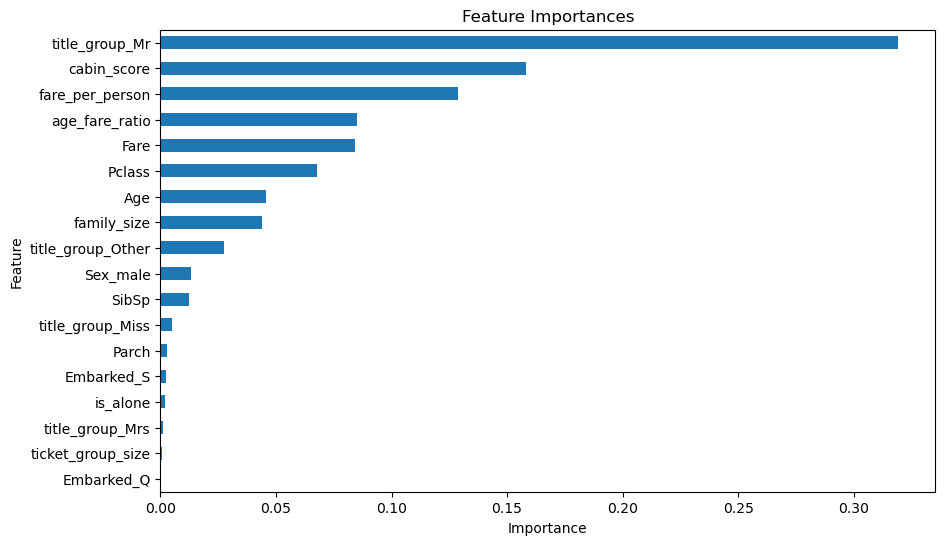

In [21]:
#see & plot how important each feature is
importances = pd.Series(decision_tree.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending = False)
print(importances)

plt.figure(figsize=(10, 6))
importances.plot(kind="barh")
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()

In [22]:
#drop least important features (trial and error to see how many should be removed to get the highest accuracy)

to_drop = [
    "Embarked_Q",
    "ticket_group_size",
    "title_group_Mrs"]

#dropping least important from training and test sets
X_train = X_train.drop(to_drop, axis=1)
X_test = X_test.drop(to_drop, axis=1)

#redo tree with only important features
decision_tree.fit(X_train, y_train)

#see new accuracy
accuracy = decision_tree.score(X_test, y_test)
print(accuracy)

0.7533632286995515


Dropping the three least important features (lots of trial and error with last 7-8 features) improves the accuracy by about 1%. The accuracy is still only 75.34% so we need to do more tuning.

In [23]:
#test out some different trees to see which gives highest accuracy (different tree depths and minimum number of samples at each final node) 
depths = [3, 4, 5, 6, 7, 8]
leaf_sizes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

results = []

for depth in depths:
    for leaf in leaf_sizes:
        decision_tree = DecisionTreeClassifier(
            max_depth = depth,
            min_samples_leaf = leaf,
            random_state=42)
        
        decision_tree.fit(X_train, y_train)
        accuracy = decision_tree.score(X_test, y_test)
        
        print("max_depth:", depth,
              "min_samples_leaf:", leaf,
              "accuracy:", accuracy)
        
        results.append([depth, leaf, accuracy])

max_depth: 3 min_samples_leaf: 1 accuracy: 0.820627802690583
max_depth: 3 min_samples_leaf: 2 accuracy: 0.820627802690583
max_depth: 3 min_samples_leaf: 3 accuracy: 0.820627802690583
max_depth: 3 min_samples_leaf: 4 accuracy: 0.820627802690583
max_depth: 3 min_samples_leaf: 5 accuracy: 0.820627802690583
max_depth: 3 min_samples_leaf: 6 accuracy: 0.820627802690583
max_depth: 3 min_samples_leaf: 7 accuracy: 0.820627802690583
max_depth: 3 min_samples_leaf: 8 accuracy: 0.820627802690583
max_depth: 3 min_samples_leaf: 9 accuracy: 0.820627802690583
max_depth: 3 min_samples_leaf: 10 accuracy: 0.820627802690583
max_depth: 4 min_samples_leaf: 1 accuracy: 0.820627802690583
max_depth: 4 min_samples_leaf: 2 accuracy: 0.8071748878923767
max_depth: 4 min_samples_leaf: 3 accuracy: 0.8026905829596412
max_depth: 4 min_samples_leaf: 4 accuracy: 0.7982062780269058
max_depth: 4 min_samples_leaf: 5 accuracy: 0.8071748878923767
max_depth: 4 min_samples_leaf: 6 accuracy: 0.8116591928251121
max_depth: 4 min_s

This shows that the ideal combination is either max_depth = 6 and min_samples_leaf = 1, max_depth = 7 and min_samples_leaf = 1, or max_depth = 3 or any min_samples_leaf. The accuracy is now 82.06% regardless of which we choose.

In [24]:
#cross validation to check if my tree is generalizable or overfits

from sklearn.model_selection import cross_val_score

decision_tree_6 = DecisionTreeClassifier(
    max_depth = 6,
    min_samples_leaf = 1,
    random_state=42
)

scores_6 = cross_val_score(decision_tree_6, X_train, y_train, cv=5).mean()
print("CV accuracy:", scores_6)

CV accuracy: 0.7993827853215127


In [25]:
decision_tree_7 = DecisionTreeClassifier(
    max_depth = 7,
    min_samples_leaf = 3,
    random_state=42
)

scores_7 = cross_val_score(decision_tree_7, X_train, y_train, cv=5).mean()
print("CV accuracy:", scores_7)

CV accuracy: 0.7739198743126472


In [26]:
decision_tree_3 = DecisionTreeClassifier(
    max_depth = 3,
    random_state=42
)

scores_3 = cross_val_score(decision_tree_3, X_train, y_train, cv=5).mean()
print("CV accuracy:", scores_3)

CV accuracy: 0.8278307709572438


I did 5 fold CV to check the generalizability of the tree I made. The CV accuracy is 79.94% for a tree with max_depth 6 and min_samples_leaf 1, 77.39% for a tree with max_depth 7 and min_samples_leaf 1, and 82.78% for a tree with max_depth = 3 and any min_samples_leaf. This shows that the best choice is max_depth 3 because it is very close to the test accuracy (82.06%), which means that it is not overfitting and generalizes well to unseen data.

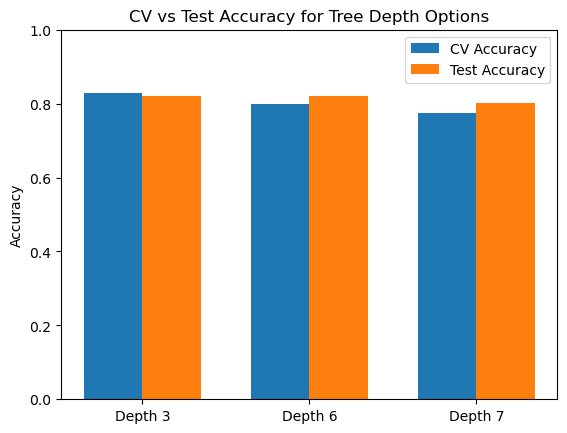

In [27]:
#chart to compare CV and test accuracy for my 2 main tree options

decision_tree_3.fit(X_train, y_train)
test_3 = decision_tree_3.score(X_test, y_test)

decision_tree_6.fit(X_train, y_train)
test_6 = decision_tree_6.score(X_test, y_test)

decision_tree_7.fit(X_train, y_train)
test_7 = decision_tree_7.score(X_test, y_test)

depths = ["Depth 3", "Depth 6", "Depth 7"]
CV_means = [scores_3, scores_6, scores_7]
test_scores = [test_3, test_6, test_7]

x = np.arange(len(depths))
width = 0.35

plt.figure()
plt.bar(x - width/2, CV_means, width, label='CV Accuracy')
plt.bar(x + width/2, test_scores, width, label='Test Accuracy')
plt.xticks(x, depths)
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.title("CV vs Test Accuracy for Tree Depth Options")
plt.legend()
plt.show()

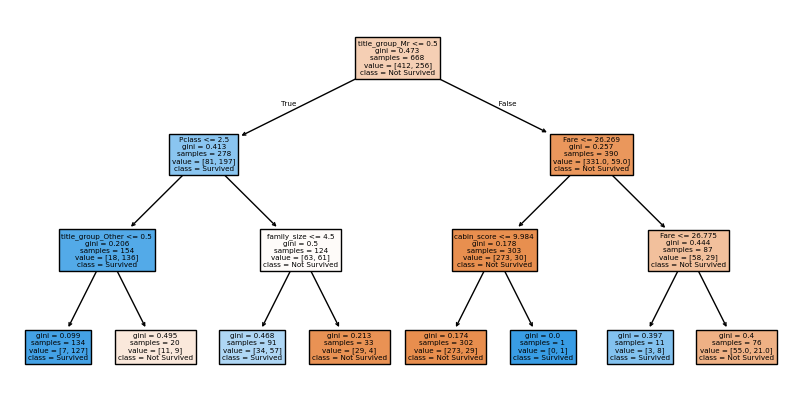

In [28]:
#plotting tree

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

final_tree = DecisionTreeClassifier(
    max_depth=3,
    random_state=42)

final_tree.fit(X_train, y_train)

plt.figure(figsize = (10, 5))
plot_tree(
    final_tree,
    feature_names=X_train.columns,
    class_names=["Not Survived", "Survived"],
    filled = True)
plt.show()

In [29]:
#plotting decisions as if/else statements for easy reading

from sklearn.tree import export_text

if_else_plot = export_text(
    final_tree,
    feature_names=list(X_train.columns)
)

print(if_else_plot)

|--- title_group_Mr <= 0.50
|   |--- Pclass <= 2.50
|   |   |--- title_group_Other <= 0.50
|   |   |   |--- class: 1
|   |   |--- title_group_Other >  0.50
|   |   |   |--- class: 0
|   |--- Pclass >  2.50
|   |   |--- family_size <= 4.50
|   |   |   |--- class: 1
|   |   |--- family_size >  4.50
|   |   |   |--- class: 0
|--- title_group_Mr >  0.50
|   |--- Fare <= 26.27
|   |   |--- cabin_score <= 9.98
|   |   |   |--- class: 0
|   |   |--- cabin_score >  9.98
|   |   |   |--- class: 1
|   |--- Fare >  26.27
|   |   |--- Fare <= 26.77
|   |   |   |--- class: 1
|   |   |--- Fare >  26.77
|   |   |   |--- class: 0



| Title Mr | Passenger Class   | Title Other | Family Size | Fare        | Cabin Score | Survived? |
|----------------|----------|-----------------|------------|------------|-------------|------------------|
| No             | ≤ 2.50   | No               | -          | -          | -           | Yes                |
| No             | ≤ 2.50   | Yes              | -          | -          | -           | No                |
| No             | > 2.50   | -                | ≤ 4.50     | -          | -           | Yes                |
| No             | > 2.50   | -                | > 4.50     | -          | -           | No                |
| Yes            | -        | -                | -          | ≤ 26.27    | ≤ 9.98      | No                |
| Yes            | -        | -                | -          | ≤ 26.27    | > 9.98      | Yes               |
| Yes            | -        | -                | -          | 26.27-26.77| -           | Yes                |
| Yes            | -        | -                | -          | > 26.77    | -           | No                |



In [31]:

result_3 = pd.DataFrame({
    "Model": [
        "Logistic Regression",
        "KNN",
        "Decision Tree"
    ],
    "Test Accuracy": [
        0.811659,   
        0.825112,  
        0.820628    
    ]
})

result_3



,Model,Test Accuracy
0,Logistic Regression,0.811659
1,KNN,0.825112
2,Decision Tree,0.820628
